# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11.51

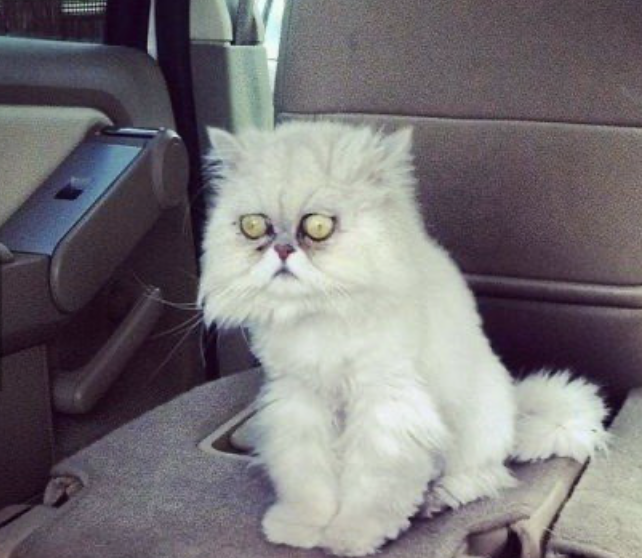

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Потому что y_random возвращает не принадлежность объекта к какому-то классу, а вероятность того, что объект принадлежит к классу +1

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [4]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


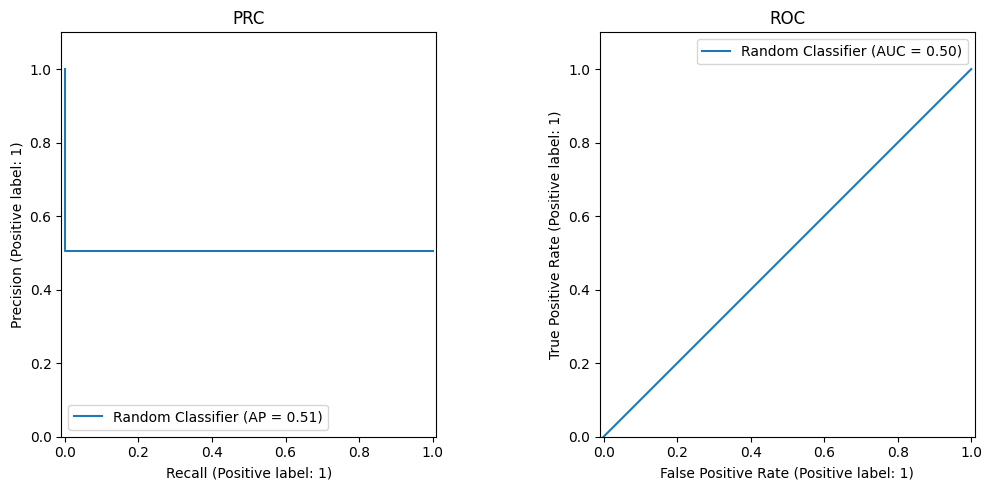

In [5]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [6]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [7]:
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV

svc = svm.LinearSVC()

param_grid = {'C': np.logspace(-4, 3, num=100)}
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=10, scoring='average_precision')
grid_search = grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
print('Оптимальное значение С: ', best_C)


Оптимальное значение С:  0.0001


In [8]:
svc = svm.LinearSVC(C=best_C)
svc = svc.fit(X_train, y_train)
svc_pred = svc.decision_function(X_test)

LinearSVC metrics
AUC-PR: 0.8299
AUC-ROC: 0.8451


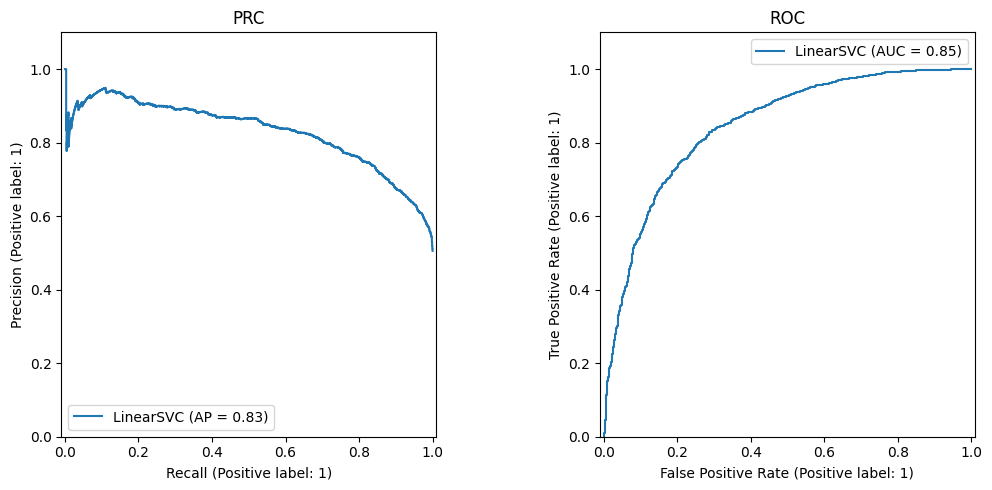

In [9]:
depict_pr_roc(y_test, svc_pred, 'LinearSVC')

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

При увеличении порога растет значение TPR и FPR, что логично, так как в точке (0, 0) на графике порог слишком большой, из-за этого никакой из имеющихся наблюдений не относится к категории FPR/TPR, затем с падением порога, растет количество объектов, которые больше него, а значит растет и количество FPR/TPR. Напомним, что FPR = FP/(FP + TN), TPR = TP/(TP + FN). По этой же причине график AUC-ROC монотонно возрастает.

При увеличении порога Precision растет, потому что модель становится более "строгой", то есть классифицирует меньше объектов как положительные. Recall наоборот убывает, так как модель пропускает больше истинных положительных примеров, выбирая только наиболее уверенные предсказания. Напомним, что формулы выглядят так: Precision = TP/(TP + FP), Recall = TP/(TP + FN). Таким образом, функция убывает. В моем случае немонотонно, это может быть связано с тем, что в модели есть группы одинаковых или похожих объектах, при минимальном изменении порога они все могут быть приняты за False positive и поэтому наблюдается резкое падение Precision.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [10]:
# your code here
df_metrics.loc['SVM'] = [
      0.8299,
      roc_auc_score(y_test, svc_pred),
      best_C,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0000
SVM,0.829900,0.845116,0.0001


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
param_grid = {'C': np.logspace(-4, 4, num=100)}
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=10, scoring='average_precision')
grid_search = grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
print('Оптимальное значение С: ', best_C)

Оптимальное значение С:  0.0003678379771828634


In [12]:
logreg = LogisticRegression(C=best_C)
logreg = logreg.fit(X_train, y_train)
logreg_pred = logreg.decision_function(X_test)

LogisticRegression metrics
AUC-PR: 0.8348
AUC-ROC: 0.8421


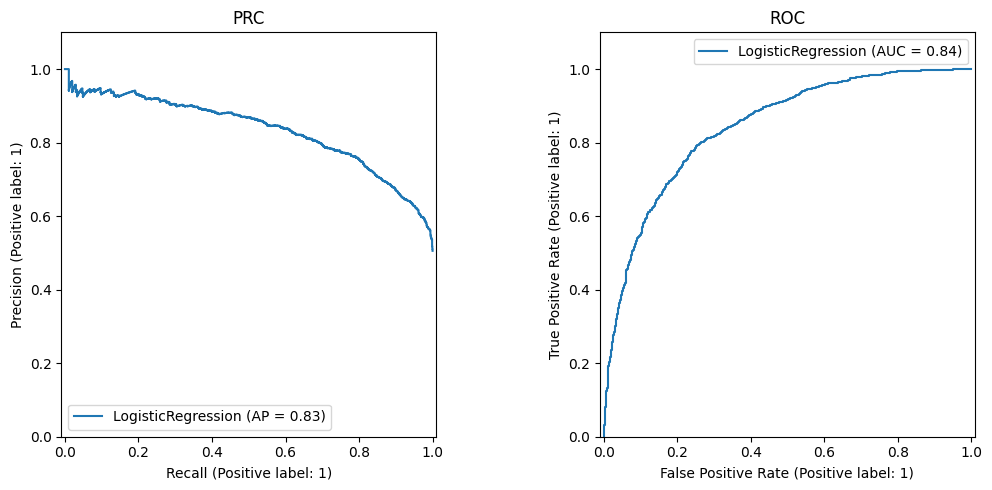

In [13]:
depict_pr_roc(y_test, logreg_pred, 'LogisticRegression')

In [14]:
df_metrics.loc['LogisticRegression'] = [
      0.8348,
      roc_auc_score(y_test, logreg_pred),
      best_C,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
SVM,0.829900,0.845116,0.000100
LogisticRegression,0.834800,0.842135,0.000368


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

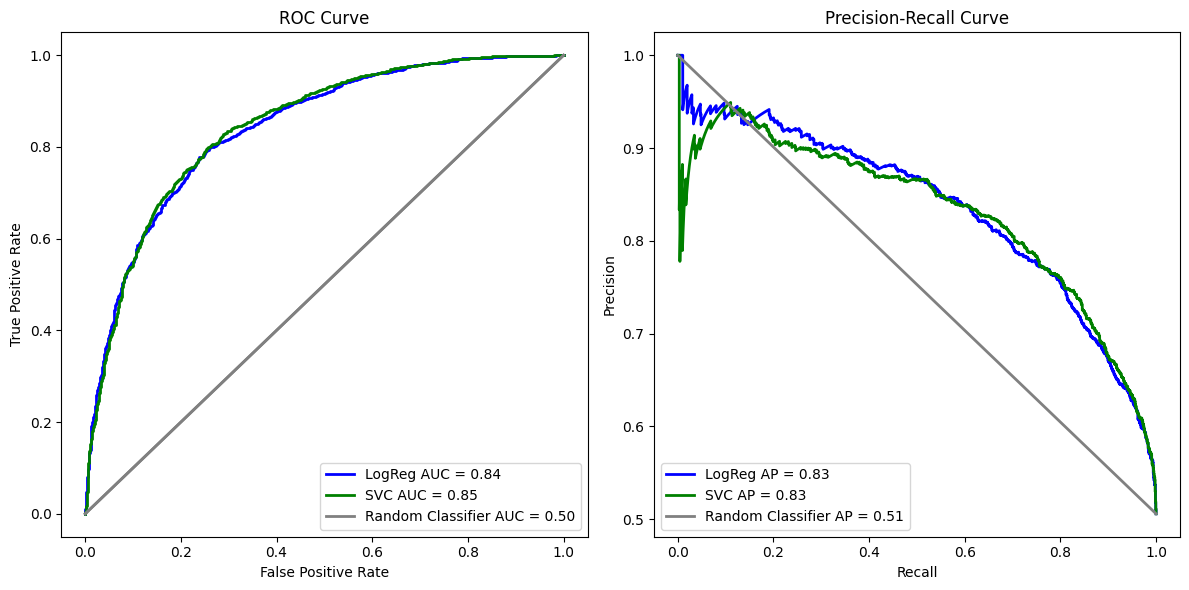

In [15]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_pred)
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_pred)
fpr_random, tpr_random, _ = roc_curve(y_test, y_random)

roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
roc_auc_svc = auc(fpr_svc, tpr_svc)
roc_auc_random = auc(fpr_random, tpr_random)

precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, logreg_pred)
precision_svc, recall_svc, _ = precision_recall_curve(y_test, svc_pred)
precision_random, recall_random, _ = precision_recall_curve(y_test, y_random)


average_precision_logreg = average_precision_score(y_test, logreg_pred)
average_precision_svc = average_precision_score(y_test, svc_pred)
average_precision_random = average_precision_score(y_test, y_random)


plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label='LogReg AUC = {:.2f}'.format(roc_auc_logreg))
plt.plot(fpr_svc, tpr_svc, color='green', lw=2, label='SVC AUC = {:.2f}'.format(roc_auc_svc))
plt.plot(fpr_random, tpr_random, color='gray', lw=2, label='Random Classifier AUC = {:.2f}'.format(roc_auc_random))
plt.plot([0, 1], [0, 1], color='gray', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_logreg, precision_logreg, color='blue', lw=2, label='LogReg AP = {:.2f}'.format(average_precision_logreg))
plt.plot(recall_svc, precision_svc, color='green', lw=2, label='SVC AP = {:.2f}'.format(average_precision_svc))
plt.plot(recall_random, precision_random, color='gray', lw=2, label='Random Classifier AP = {:.2f}'.format(average_precision_random))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** ROC кривые у линейной регрессии и метода опорных векторов практически идентичные. Кривые precision-recall тоже очень похожие, за исключением провала кривой у SVC в самом начале. Вероятно, это связано с построением моделей: логистическая регрессия дает более плавные значения, так как считает вероятности, в то время как SVC строит разделяющую гиперплоскость с помощью всяких линейных алгебр, что может способствовать появлению скачков на PR-кривой.

Можно заметить, что у SVM значение AUC-ROC немного повыше, вероятно это связано с тем, что функция потерь логистической регрессии стремится в бесконечность, в то время как функция потерь SVM после 1 остается на уровне 0, засчет чего модель не тратит лишние силы на вычисление уже неважных значений.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [16]:
# your code here
from sklearn.datasets import make_classification
random_state_value = 42
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=random_state_value)

df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['Target'] = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
df.head()
model = svm.SVC(random_state=94, kernel='linear')
model = model.fit(X_train, y_train)

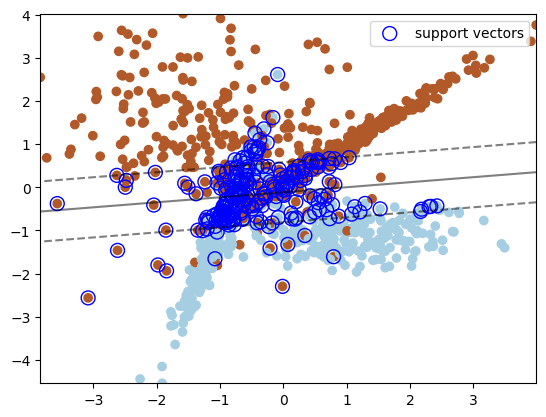

In [17]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy)
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
       X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0], model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** При решении задачи классификации методом опорных векторов, можно представить эту задачу через поис чедловой точки функции Лагранжа. Вот опорный объект - это тот, у котого соответствующий множитель лагранжа отличен от 0. Геометрически опорные объекты - это близкие к гиперплоскости объекты, наиболее влияющие на построение гиперплоскости. В нашем случае хорошо видно, что некоторые выбросы также считаются опорными, хотя находятся далеко от гиперплоскости, так как они сильно влияют на нее.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [18]:
model_log = LogisticRegression()
model_log = model_log.fit(X_train, y_train)

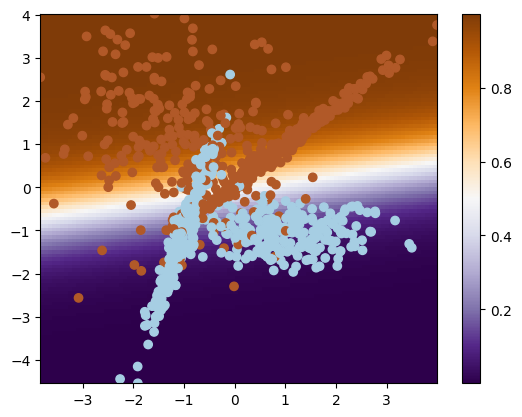

In [19]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X, y, model_log)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Она визуализирована белым цветом на пересечении классов. Это связано с тем, что вероятность принадлежности объекта к классу 1 задается формулой: 
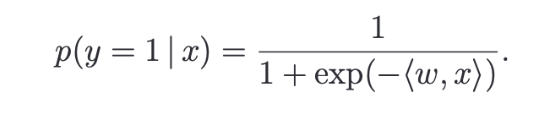

И чтобы вероятность получилась 0.5, отступ под экспонентой должен быть равен 0, то есть модель не знает, куда относить этот объект.


#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [20]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r + l) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.plot([0, 1], [0, 1])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

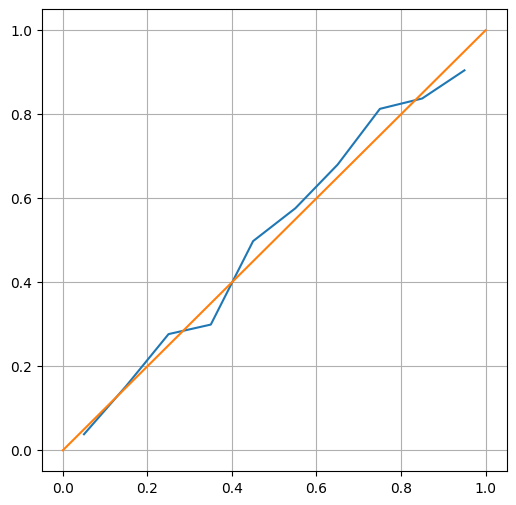

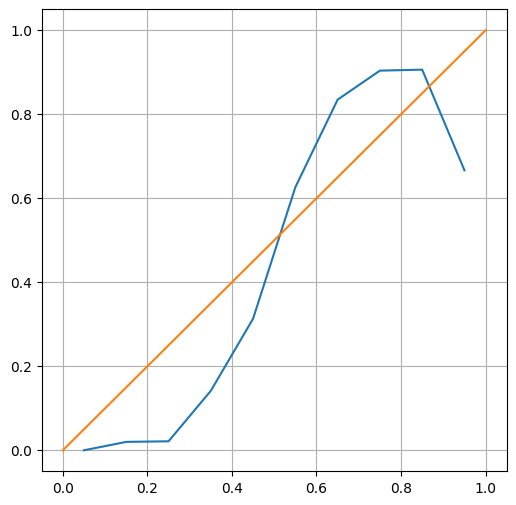

In [21]:
# your code here
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model_log = LogisticRegression()
model_log = model_log.fit(X_train, y_train)
logreg_pred = model_log.predict_proba(X_test)[:, 1]

model_svc = LinearSVC()
model_svc = model_svc.fit(X_train, y_train)
svc_pred = model_svc.decision_function(X_test)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min())
plot_calibration_curve(y_test, logreg_pred)

plt.show(plot_calibration_curve(y_test, svc_pred))

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** Логистическая регрессия как будто очень неплохо откалибрована, так как она практически повторяет форму диагонали, за исключением каких-то небольших отклонений. SVM не очень, она очень отклоняется от траектории диагонали, проходя выше после 0.5, ниже до 0.5, а падение после 0.8 это вообще не очень хорошо.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [22]:
from sklearn import metrics
log_loss_ = metrics.log_loss(y_test, logreg_pred)
brierscore_ = metrics.brier_score_loss(y_test, svc_pred)
print(f'LogLoss: {log_loss_}')
print(f'BrierScore: {brierscore_}')

LogLoss: 0.4858556295167715
BrierScore: 0.18448816470208299


Ладно, я переборщила, возможно не так уж все и круто предскзыавет, судя по значениям функций, но LogLoss все еще лучше работает значительно.

Изучите распределение ответов классификаторов при помощи гистограмм

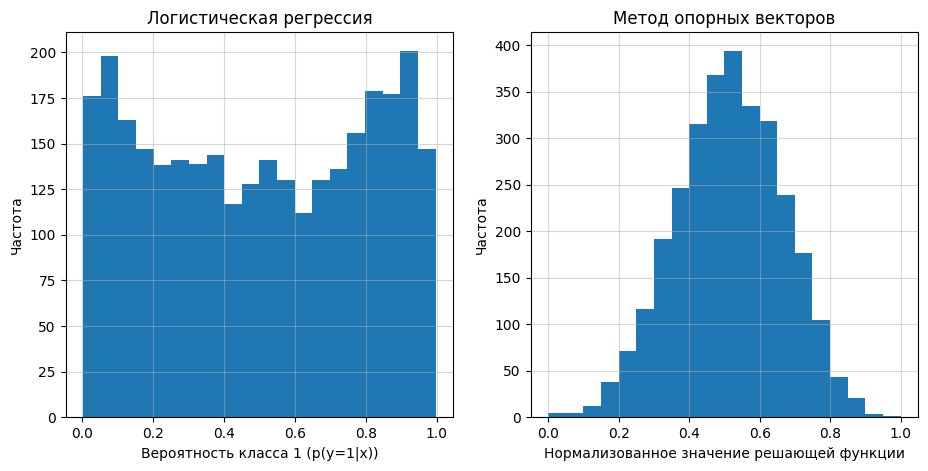

In [23]:
# your code here
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
axs[0].hist(logreg_pred, bins=20)
axs[0].set_title('Логистическая регрессия')
axs[0].set_xlabel('Вероятность класса 1 (p(y=1|x))')
axs[0].set_ylabel('Частота')
axs[0].grid(alpha=0.5)

axs[1].hist(svc_pred, bins=20)
axs[1].set_title('Метод опорных векторов')
axs[1].set_xlabel('Нормализованное значение решающей функции')
axs[1].set_ylabel('Частота')
axs[1].grid(alpha=0.5)

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Я думаю, это связано с тем, что у логистической регресссии тяжелые веса на концах, так как у логистической регрессии более тяжелое оценивание из-за формы ее функционала ошибки, которая стремится улететь в бесконечность.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

Калибровочная кривая для метода опорных векторов


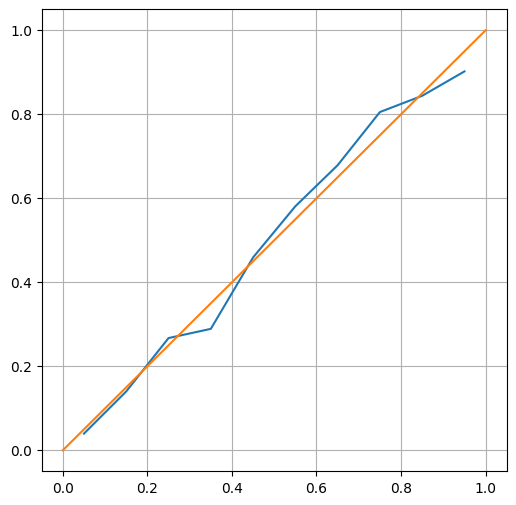

In [24]:
from sklearn.calibration import CalibratedClassifierCV
model_svc = LinearSVC()
model_svc = model_svc.fit(X_train, y_train)
svc_pred = model_svc.decision_function(X_test)
calibrated_svc = CalibratedClassifierCV()
calibrated_svc.fit(svc_pred.reshape(-1, 1), y_test)
svc_pred = calibrated_svc.predict_proba(svc_pred.reshape(-1, 1))[:, 1]

print('Калибровочная кривая для метода опорных векторов')
plot_calibration_curve(y_test, svc_pred)

In [25]:
log_loss_ = metrics.log_loss(y_test, svc_pred)
log_loss_

0.4859987834521933

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Улучшилось чуть чуть.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Я реализовывала Platt Calibration: взяла логистическую регрессию, обучила на ней модель и взяла полученные вероятности, на которых, в свою очередь, обучила логистическую регрессию, чтобы откалибровать

In [26]:
def platt(preds, y_temp):
    model_platt = LogisticRegression()
    model_platt.fit(preds.reshape(-1, 1), y_temp)
    calibrated_probs = model_platt.predict_proba(preds.reshape(-1, 1))[:, 1]
    return calibrated_probs

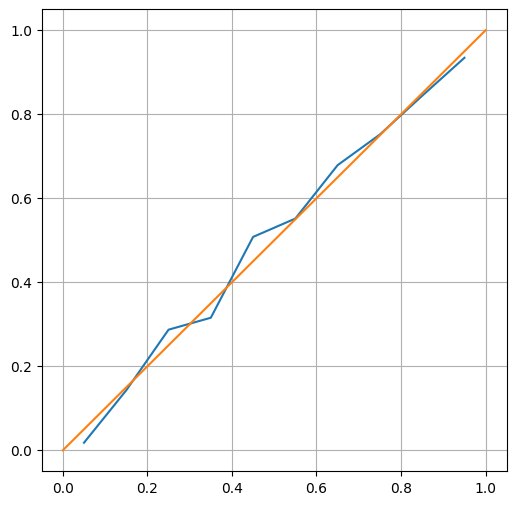

In [27]:
model_log = LogisticRegression()
model_log.fit(X_train, y_train)
logreg_probs = model_log.predict_proba(X_test)[:, 1]
platt_calibrated_probs = platt(logreg_probs, y_test)
plot_calibration_curve(y_test, platt_calibrated_probs)

In [28]:
log_loss_ = metrics.log_loss(y_test, platt_calibrated_probs)
log_loss_ #чуть чуть выросла

0.486140677317851

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [29]:
! pip install kagglehub


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [30]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
df

,Feature 1,Feature 2,Target
0,-0.999102,-0.663860,1
1,1.246686,1.153597,1
2,0.962777,0.859397,1
3,-2.957441,2.033645,1
4,1.141165,1.059449,1
...,...,...,...
995,-0.432774,0.890930,0
996,1.020438,1.164617,1
997,-0.101267,-1.590176,0
998,0.643761,-0.780539,0


In [32]:
# Прочитаем датасет
df = pd.read_csv(path)

# Заменим пропуски категориальных переменных
category = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
            'Commute Distance', 'Region', "Purchased Bike"]
df[category] = df[category].fillna('undefined')

# Отделим X и y
y = df['Purchased Bike']
X = df.loc[: ,df.columns != 'Purchased Bike']
# your code here

# Разделим на категориальные признаки и числовые
X_numerical = df[['Income', 'Children', 'Cars', 'Age']]
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner',
            'Commute Distance', 'Region']
X_categorical = df[categorical]

In [33]:
df

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,undefined,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


В начале поработаем только с категориальными признаками

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [35]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

start_time = time.time()

encoder = OrdinalEncoder()
y_encoded = encoder.fit_transform(y.to_frame())


X_train, X_test, y_train, y_test = train_test_split(X_categorical, y_encoded, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer([
    ('ohe', OrdinalEncoder(handle_unknown='error'), categorical),
])

pipeline = Pipeline(steps = [
                    ('ohe', column_transformer),
                    ('regression', LogisticRegression())
])


model_log = LogisticRegression()

model_log = pipeline.fit(X_train, y_train)
end_time = time.time()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC-PR: 0.5886533539773633


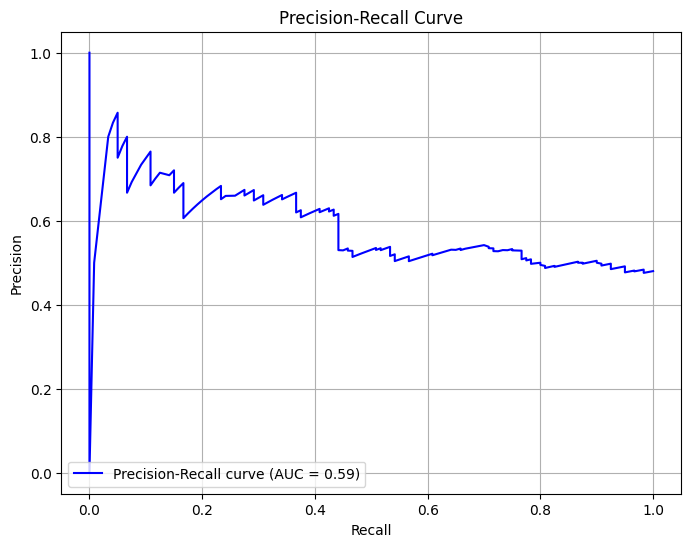

In [36]:

y_prob = model_log.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [37]:
elapsed_time = end_time - start_time
print(elapsed_time, 'секунд на обучение модели')

0.00659489631652832 секунд на обучение модели


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

AUC-PR: 0.6662544177340515


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


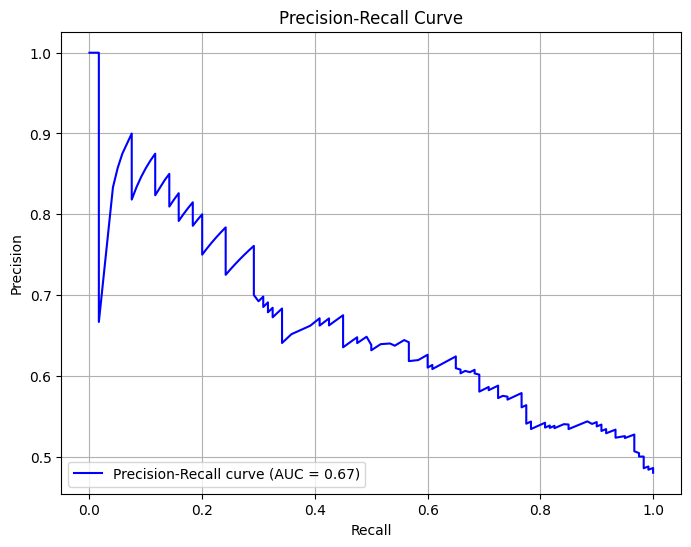

In [38]:
# your code here
from sklearn.preprocessing import OneHotEncoder
start_time = time.time()

encoder = OrdinalEncoder()
y_encoded = encoder.fit_transform(y.to_frame())


X_train, X_test, y_train, y_test = train_test_split(X_categorical, y_encoded, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='error'), categorical),
])

pipeline = Pipeline(steps = [
                    ('ohe', column_transformer),
                    ('regression', LogisticRegression())
])

model_log = LogisticRegression()

model_log = pipeline.fit(X_train, y_train)
end_time = time.time()


y_prob = model_log.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [39]:
elapsed_time = end_time - start_time
print(elapsed_time, 'секунд на обучение модели')

0.013711929321289062 секунд на обучение модели


Качество модели выросло

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

AUC-PR: 0.7054428604898514


/var/folders/4j/3c8wjnt562b02zdm0wpb8cl80000gn/T/ipykernel_59877/798791391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_categorical['pur'] = y_encoded
/var/folders/4j/3c8wjnt562b02zdm0wpb8cl80000gn/T/ipykernel_59877/798791391.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_categorical[col] = X_categorical[col].map(mean_target)
/var/folders/4j/3c8wjnt562b02zdm0wpb8cl80000gn/T/ipykernel_59877/798791391.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

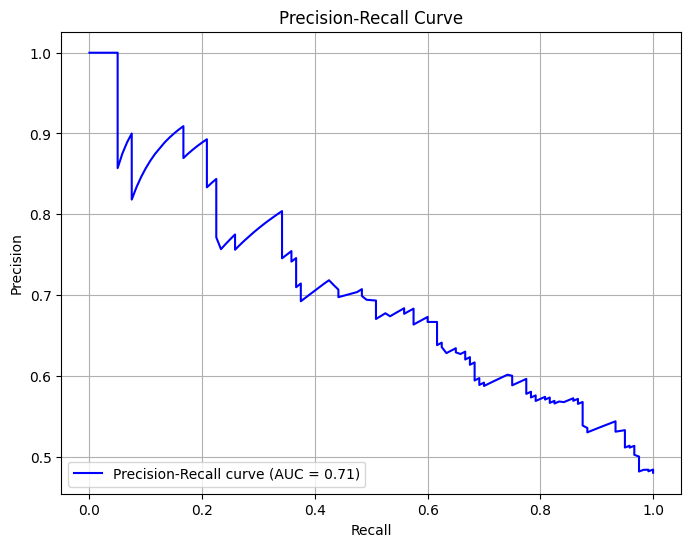

In [40]:
start_time = time.time()
X_categorical['pur'] = y_encoded
for col in X_categorical.columns:
    if col != 'pur':
        mean_target = X_categorical.groupby(X_categorical[col]).agg({'pur': 'mean'})['pur']
        X_categorical[col] = X_categorical[col].map(mean_target)

X_categorical = X_categorical.drop('pur', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y_encoded, test_size=0.25, random_state=777, stratify=y)

model1 = LogisticRegression()
model1.fit(X_train, y_train)
end_time = time.time()
y_prob = model1.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

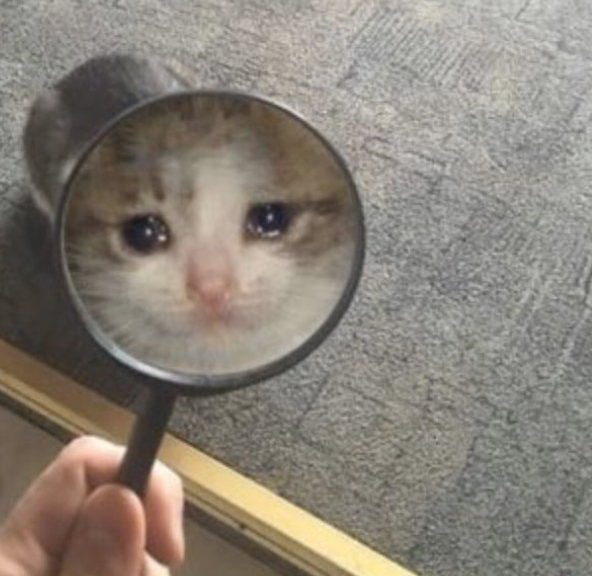

In [41]:
elapsed_time = end_time - start_time
print(elapsed_time, 'секунд на обучение модели')

0.009476184844970703 секунд на обучение модели


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.global_mean_ = None
        self.category_means_ = {}
        self.columns = []
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, pd.Series):
            y = pd.Series(y.ravel(), name="target")
        self.global_mean_ = y.mean()
        self.columns = X.columns.tolist()
        for col in self.columns:
            self.category_means_[col] = X[[col]].join(y).groupby(col)[y.name].mean()
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X_encoded = X.copy()
        for col in self.columns:
            if col in self.category_means_:
                X_encoded[col] = X_encoded[col].map(self.category_means_[col]).fillna(self.global_mean_)

        return X_encoded


AUC-PR: 0.7054428604898514


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


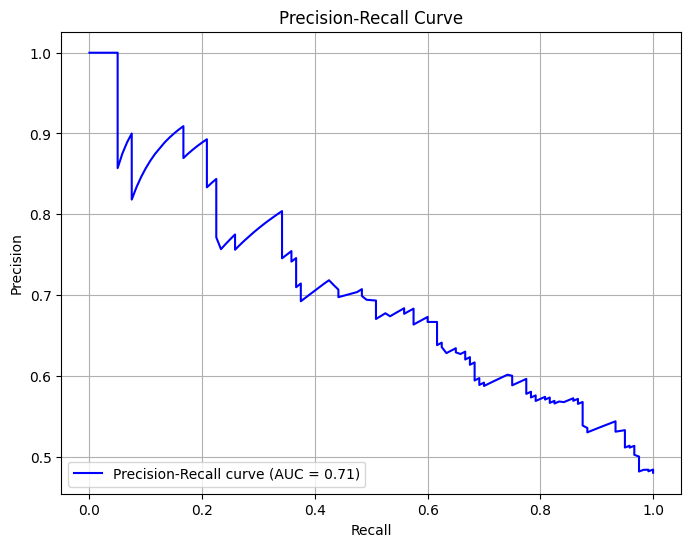

In [43]:

encoder = MeanTargetEncoder()
encoder.fit(X_categorical, y_encoded)

X_encoded = encoder.transform(X_categorical)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.25, random_state=777, stratify=y)

model2 = LogisticRegression()
model2.fit(X_train, y_train)
end_time = time.time()
y_prob = model2.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

AUC-PR: 0.6882863050241281


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


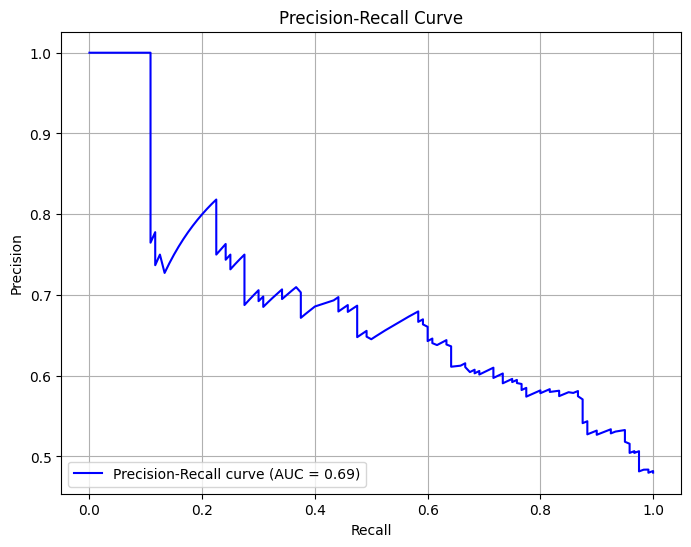

In [44]:
# your code here
def add_noise(series, noise_level=0.05):
    noise = np.random.uniform(-1, 1, size=len(series)) * noise_level
    return series + noise
start_time = time.time()
X_categorical['pur'] = y_encoded
for col in X_categorical.columns:
    if col != 'pur':
        mean_target = X_categorical.groupby(X_categorical[col]).agg({'pur': 'mean'})['pur']
        mean_target = add_noise(mean_target)
        X_categorical[col] = X_categorical[col].map(mean_target)

X_categorical = X_categorical.drop('pur', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y_encoded, test_size=0.25, random_state=777, stratify=y)

model3 = LogisticRegression()
model3.fit(X_train, y_train)
end_time = time.time()
y_prob = model3.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума ухудшило качество предсказаний, что логично, так как, добавляя шум, мы ухудшаем качество данных, на которых модели нужно делать выводы, но глобально это нужно делать, чтобы модель не переобучалась.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [45]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [46]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, C=10):
        self.global_mean_ = None
        self.category_means_ = {}
        self.columns = []
        self.C = C
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if not isinstance(y, pd.Series):
            y = pd.Series(y.ravel(), name="target")
        self.global_mean_ = y.mean()
        self.columns = X.columns.tolist()
        for col in self.columns:
            category_counts = X.groupby(col).size()
            category_sums = X.join(y).groupby(col)[y.name].sum()

            category_means = (category_sums + self.C * self.global_mean_) / (category_counts + self.C)
            self.category_means_[col] = category_means
            self.category_means_[col] = add_noise(self.category_means_[col])

        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X_encoded = X.copy()
        for col in self.columns:
            if col in self.category_means_:
                X_encoded[col] = X_encoded[col].map(self.category_means_[col]).fillna(self.global_mean_)

        return X_encoded

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC-PR: 0.9557840325610634


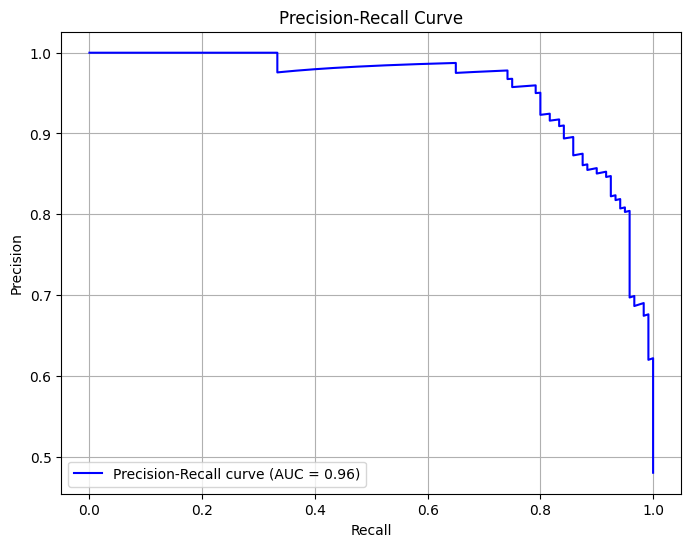

In [47]:
start_time = time.time()

encoder = MeanTargetEncoder(C=10)
encoder.fit(X, y_encoded)
X_encoded = encoder.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.25, random_state=777, stratify=y)

model4 = LogisticRegression()
model4.fit(X_train, y_train)
end_time = time.time()
y_prob = model4.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [48]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

0.9559615384615384

ээээээээээ вот это да конечно

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [49]:
#Некоторые пустые значения лучше заполнять средним (уровень зарплаты, возраст), а некоторые медианой (например, количество детей и машин, не хочется чтобы у бро было 3.5 ребенка)

df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Income'] = df['Income'].fillna(df['Income'].mean())
df['Children'] = df['Children'].fillna(df['Children'].median())
df['Cars'] = df['Cars'].fillna(df['Cars'].median())

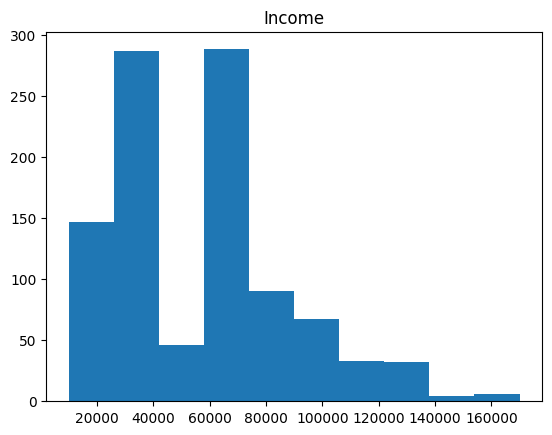

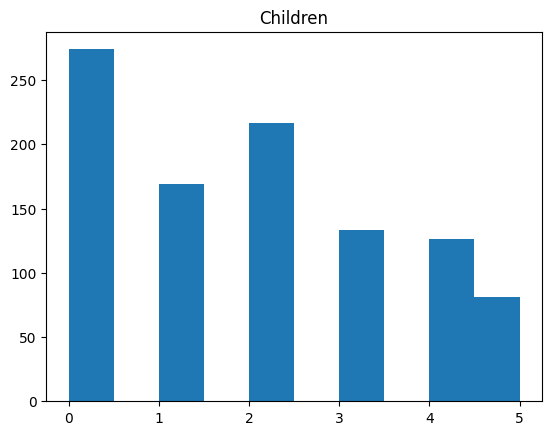

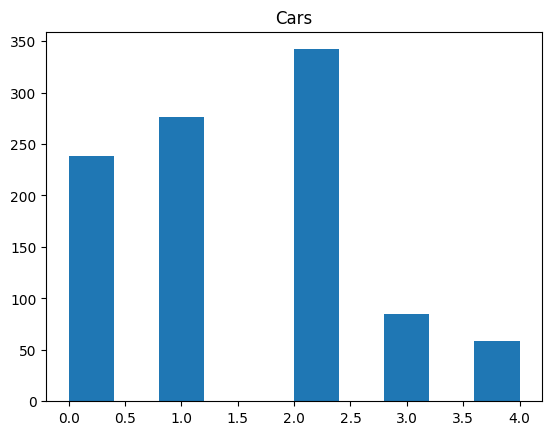

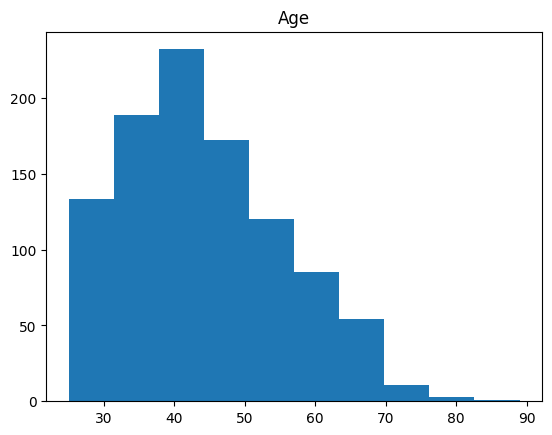

In [50]:
numeric = ['Income', 'Children', 'Cars', 'Age']
for col in numeric:
    plt.hist(df[col], bins=10)
    plt.title(col)
    plt.show()

Ну, норм)

In [51]:
X = df.loc[: ,df.columns != 'Purchased Bike']
df['Purchased Bike'] = df['Purchased Bike'].replace({'Yes': 1, 'No': 0})
y = df['Purchased Bike']

/var/folders/4j/3c8wjnt562b02zdm0wpb8cl80000gn/T/ipykernel_59877/2275997902.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Purchased Bike'] = df['Purchased Bike'].replace({'Yes': 1, 'No': 0})


In [52]:
X = X.drop('ID', axis=1)

AUC-PR: 0.6662544177340515


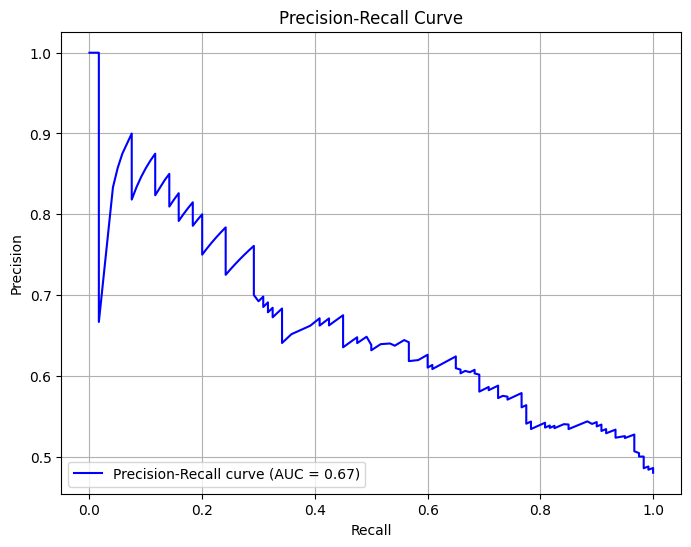

In [53]:
# your code here
from sklearn.preprocessing import OneHotEncoder
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

column_transformer = ColumnTransformer([
     ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
])

pipeline = Pipeline(steps = [
                    ('ohe', column_transformer),
                    ('regression', LogisticRegression())
])


model_log = pipeline.fit(X_train, y_train)

y_prob = model_log.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

Результат практически не изменился

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [54]:
#Посмотрим кол-во уникальных значений для числовых признаков
print('Income: ', df['Income'].nunique())
print('Age: ', df['Age'].nunique())
print('Car: ', df['Cars'].nunique())
print('Children: ', df['Children'].nunique())

Income:  17
Age:  54
Car:  5
Children:  6


In [55]:
y

0      0
1      0
2      0
3      1
4      1
      ..
995    1
996    1
997    1
998    0
999    1
Name: Purchased Bike, Length: 1000, dtype: int64

Ну не так уж и много ахаххаха

AUC-PR: 0.7278706305636459


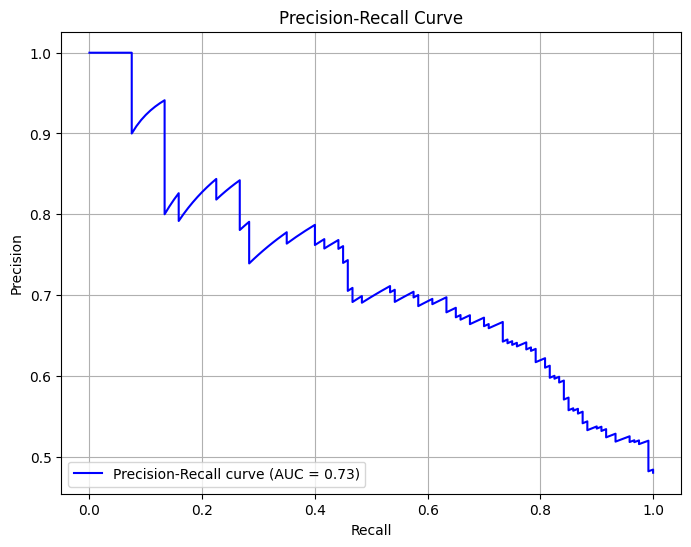

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression



X = df.loc[: ,df.columns != 'Purchased Bike']
df['Purchased Bike'] = df['Purchased Bike'].replace({'Yes': 1, 'No': 0})
y = df['Purchased Bike']

start_time = time.time()
X['pur'] = y
for col in categorical:
    if col != 'pur':
        mean_target = X.groupby(X[col]).agg({'pur': 'mean'})['pur']
        X[col] = X[col].map(mean_target)

X = X.drop('pur', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])
pipeline.fit(X_train, y_train)

end_time = time.time()
y_prob = pipeline.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

Результат получше

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ One-hot кодирование очень раздувает количество данных, чем проигрывают счетчикам. Также счетчики используют связь между категориальным признаком и целевой переменной, что повышает качество модели. В случае большого числа категорий one-hot-кодирование может приводить к мультиколлинеарности, тогда как счётчики этой проблемы не создают. При этом у счетчиков высокий риск переобучения, так как счетчики используют целевую переменную. Если целевая переменная несбалансирована, то счётчики могут нести мало информации, так как большинство категорий будет приближаться к глобальному среднему значению.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [57]:
! pip install wget


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [ ]:
#!curl -o adult.data https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3881k    0 3881k    0     0  1048k      0 --:--:--  0:00:03 --:--:-- 1048k


In [204]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
17294,41,Private,111483,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,45,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [205]:
# your code here
X = df.drop(columns=['income']) 
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [206]:
category = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
coder = OneHotEncoder()
X_hot = coder.fit_transform(X)

In [207]:
for i in category:
    print(i, df[i].nunique())

workclass 9
education 16
marital-status 7
occupation 15
relationship 6
race 5
sex 2
native-country 42


вот сколько разных значений в категориальных признаках, столько и новых признаков

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

AUC-PR: 0.7672340764944497


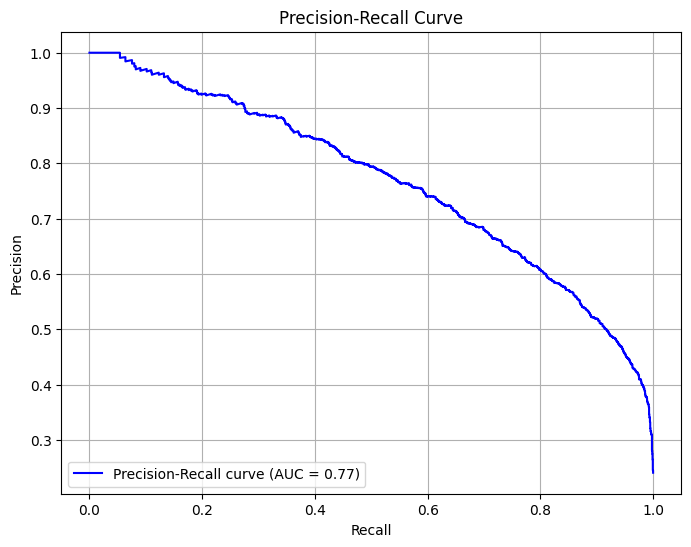

In [208]:
# your code here
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)
time_start = time.time()
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='error'), category),
    ('scaling', StandardScaler(), numeric_features)

])

pipeline = Pipeline(steps = [
                    ('ohe', column_transformer),
                    ('regression', LogisticRegression())
])

model_log = LogisticRegression()

model_log = pipeline.fit(X_train, y_train)

y_prob = model_log.predict_proba(X_test)[:, 1]
time_finish = time.time()
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


In [209]:
time_diff =time_finish - time_start
time_diff

0.11760807037353516

Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [210]:
print(X_test.shape)
print(y_test.shape)

(8141, 14)
(8141,)


In [ ]:
# your code here
X_test_valid, X_valid, y_test_valid, y_valid = train_test_split(X_test, y_test, test_size=0.3, random_state=777, stratify=y_test)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или x, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



AUC-PR: 0.6802547831520223


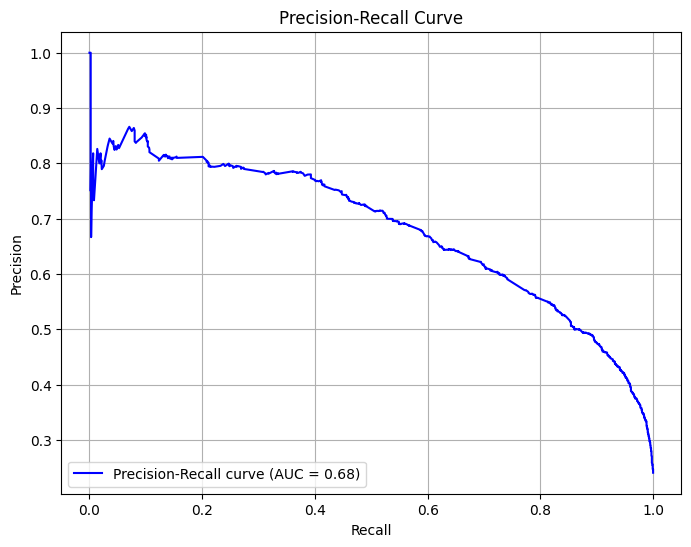

In [212]:
time_start = time.time()
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='error'), category)

])

pipeline = Pipeline(steps = [
                    ('ohe', column_transformer),
                    ('classifier', LogisticRegression())
])

model_log = LogisticRegression()

model_log = pipeline.fit(X_train, y_train)

y_prob = model_log.predict_proba(X_test_valid)[:, 1]
time_finish = time.time()

precision, recall, thresholds = precision_recall_curve(y_test_valid, y_prob)
auc_pr = average_precision_score(y_test_valid, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


In [213]:
time_diff =time_finish - time_start
time_diff

0.06696200370788574

age	workclass	fnlwgt	education	education-num	marital-status	occupation	relationship	race	sex	capital-gain	capital-loss	hours-per-week	native-country	

In [ ]:
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
column_transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), category),
        ('scaler', StandardScaler(), numerical)
    ], 

)

pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))
])

pipeline.fit(X_train, y_train)
model = pipeline.named_steps['classifier']
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)

coefs = model.coef_.flatten()



ohe_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(category)

all_columns = np.concatenate([ohe_columns, numerical])

important_indices = abs(coefs).argsort()[-40:][::-1]
important_columns = [all_columns[i] for i in important_indices]


feature_importance = pd.DataFrame({
    'Feature': all_columns,
    'Coefficient': coefs
})

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

print(feature_importance.head(40))


                                   Feature  Coefficient  Abs_Coefficient
22                    education_ Preschool    -2.750830         2.750830
26       marital-status_ Married-AF-spouse     2.429525         2.429525
105                           capital-gain     2.350008         2.350008
41             occupation_ Priv-house-serv    -2.286638         2.286638
27      marital-status_ Married-civ-spouse     1.953570         1.953570
64                native-country_ Columbia    -1.276839         1.276839
37             occupation_ Farming-fishing    -1.141567         1.141567
50                 relationship_ Own-child    -1.030706         1.030706
52                      relationship_ Wife     0.918833         0.918833
62                  native-country_ Canada     0.895110         0.895110
40               occupation_ Other-service    -0.889012         0.889012
58                             sex_ Female    -0.872005         0.872005
61                native-country_ Cambodia     0.85

In [215]:
X_train_help = column_transformer.fit_transform(X_train, y_train).toarray()
X_test_help = column_transformer.transform(X_test).toarray()

X_train_40 = X_train_help[:, important_indices]
X_test_40 = X_test_help[:,important_indices]

In [216]:
model33 = LogisticRegression()
model33.fit(X_train_40, y_train)
y_pred = model33.predict_proba(X_test_40)[:, 1]


AUC-ROC: 0.8994024231598481
AUC-PR: 0.7490631578701069


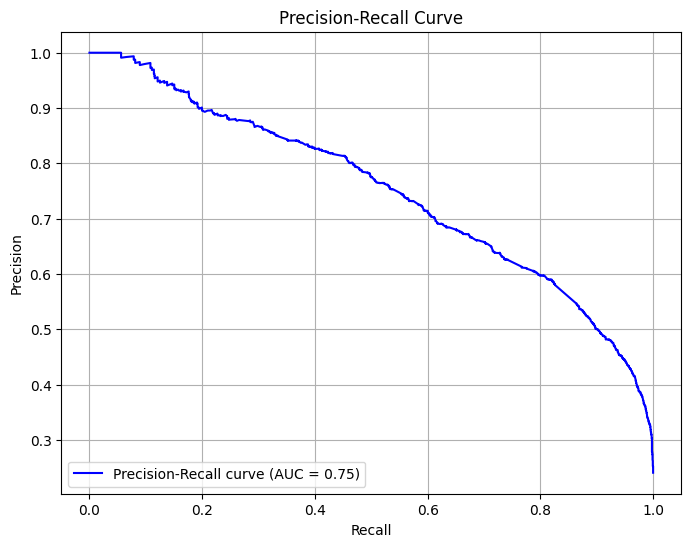

In [217]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC: {roc_auc}' )
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

Изменилось ли качество? Как?

Качество выросло.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [218]:
# your code here
column_transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), category)
    ], 
)

pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))
])
pipeline.fit(X_train, y_train)
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
model = pipeline.named_steps['classifier']
coefs = model.coef_.flatten()
important_indices = abs(coefs).argsort()[-40:][::-1]
important_columns = [all_columns[i] for i in important_indices]


ohe_columns = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(category)

all_columns = ohe_columns

feature_importance = pd.DataFrame({
    'Feature': all_columns,
    'Coefficient': coefs
})

feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

print(feature_importance.head(40))

                                  Feature  Coefficient  Abs_Coefficient
19                   education_ Doctorate     2.545123         2.545123
23                 education_ Prof-school     2.331802         2.331802
41            occupation_ Priv-house-serv    -1.896728         1.896728
21                     education_ Masters     1.679963         1.679963
26      marital-status_ Married-AF-spouse     1.484066         1.484066
27     marital-status_ Married-civ-spouse     1.401705         1.401705
64               native-country_ Columbia    -1.306542         1.306542
50                relationship_ Own-child    -1.271488         1.271488
29          marital-status_ Never-married    -1.168682         1.168682
18                   education_ Bachelors     1.104397         1.104397
61               native-country_ Cambodia     1.037761         1.037761
52                     relationship_ Wife     1.017525         1.017525
14                     education_ 7th-8th    -0.990682         0

In [219]:
X_train_help = column_transformer.fit_transform(X_train, y_train).toarray()
X_test_help = column_transformer.transform(X_test).toarray()

X_train_40 = X_train_help[:, important_indices]
X_test_40 = X_test_help[:,important_indices]

In [220]:
model34 = LogisticRegression()
model34.fit(X_train_40, y_train)
y_pred = model33.predict_proba(X_test_40)[:, 1]

AUC-ROC: 0.24651322023713224
AUC-PR: 0.16259105193100815


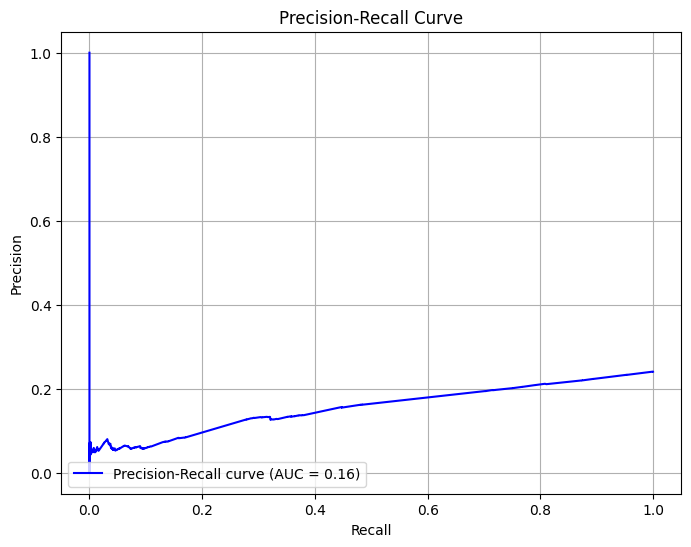

In [221]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'AUC-ROC: {roc_auc}' )
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [222]:
important_indices = abs(coefs).argsort()[::-1]
important_columns = [all_columns[i] for i in important_indices]
important_columns

['education_ Doctorate',
 'education_ Prof-school',
 'occupation_ Priv-house-serv',
 'education_ Masters',
 'marital-status_ Married-AF-spouse',
 'marital-status_ Married-civ-spouse',
 'native-country_ Columbia',
 'relationship_ Own-child',
 'marital-status_ Never-married',
 'education_ Bachelors',
 'native-country_ Cambodia',
 'relationship_ Wife',
 'education_ 7th-8th',
 'native-country_ Canada',
 'occupation_ Other-service',
 'sex_ Female',
 'native-country_ France',
 'education_ 9th',
 'occupation_ Exec-managerial',
 'native-country_ Italy',
 'education_ Preschool',
 'education_ 1st-4th',
 'native-country_ Germany',
 'occupation_ Farming-fishing',
 'education_ 11th',
 'education_ 10th',
 'marital-status_ Separated',
 'workclass_ Federal-gov',
 'occupation_ Handlers-cleaners',
 'native-country_ Philippines',
 'relationship_ Other-relative',
 'workclass_ Self-emp-inc',
 'native-country_ England',
 'marital-status_ Married-spouse-absent',
 'education_ 5th-6th',
 'workclass_ Without-pa

In [223]:
X_train_help = pd.DataFrame(X_train_help, columns=important_columns)
X_test_help = pd.DataFrame(X_test_help, columns=important_columns)

AUC-PR: 0.6840965298967495


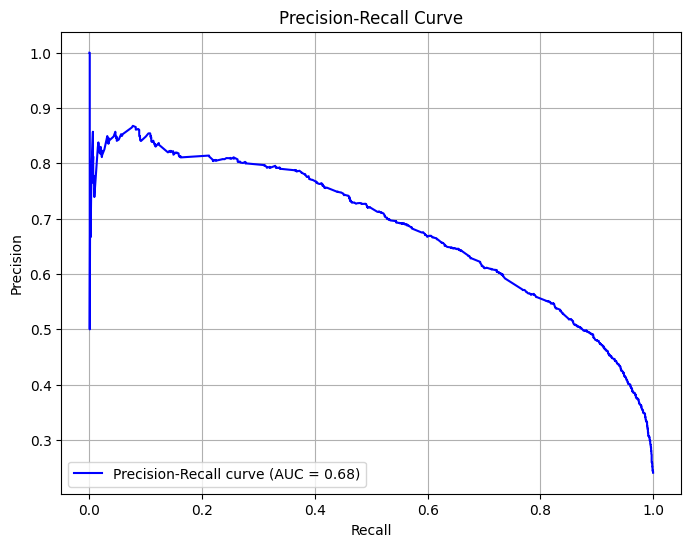

In [224]:
column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), important_columns)

])

pipeline = Pipeline(steps = [
                    ('ohe', column_transformer),
                    ('regression', LogisticRegression())
])

model_log = LogisticRegression()

model_log = pipeline.fit(X_train_help, y_train)

y_prob = model_log.predict_proba(X_test_help)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
auc_pr = average_precision_score(y_test, y_prob)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

Качество упало, но это как будто и логично, так как не совсем понятно, как скэйлинг может что-то улучшить, когда категориальные переменные имеют значения в столбцах 0 и 1.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** Чем больше корреляция, тем сильнее признак влияет на целевую переменную, тем важнее он.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [225]:
correlations = X_train_help[important_columns].corrwith(y_train)
correlations

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


education_ Doctorate                 0.001054
education_ Prof-school               0.004169
occupation_ Priv-house-serv          0.006487
education_ Masters                   0.000340
marital-status_ Married-AF-spouse   -0.012508
                                       ...   
race_ White                         -0.005384
relationship_ Unmarried              0.000481
native-country_ Vietnam             -0.001543
occupation_ Armed-Forces            -0.002788
workclass_ ?                        -0.000931
Length: 102, dtype: float64

In [226]:
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
sorted_correlations_40 = sorted_correlations[:40]
columns_corr = sorted_correlations_40.index.tolist()

In [227]:
X_train_40_corr = X_train_help[columns_corr]
X_test_40_corr = X_test_help[columns_corr]

In [228]:
start = time.time()
model34 = LogisticRegression()
model34.fit(X_train_40_corr, y_train)
y_pred = model33.predict_proba(X_test_40_corr)[:, 1]
finish = time.time()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


AUC-PR: 0.4029809920494702


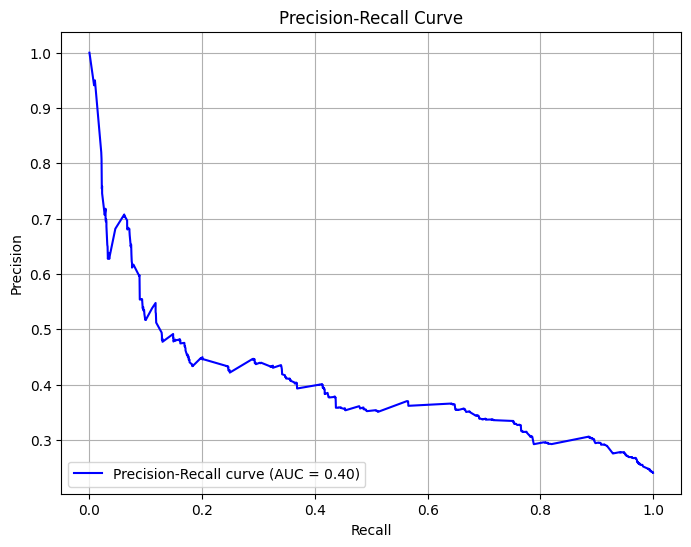

In [229]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_pred)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [230]:
process = finish-start
print('Длительность в сек: ', process)

Длительность в сек:  0.13861989974975586


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

/var/folders/4j/3c8wjnt562b02zdm0wpb8cl80000gn/T/ipykernel_59877/1015980635.py:15: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = abs(mu_pos - mu_neg) / np.sqrt((n_pos * sigma_pos**2 + n_neg * sigma_neg**2) / (n_pos + n_neg))


0.291262149810791 секунд
AUC-PR: 0.6163936960710532


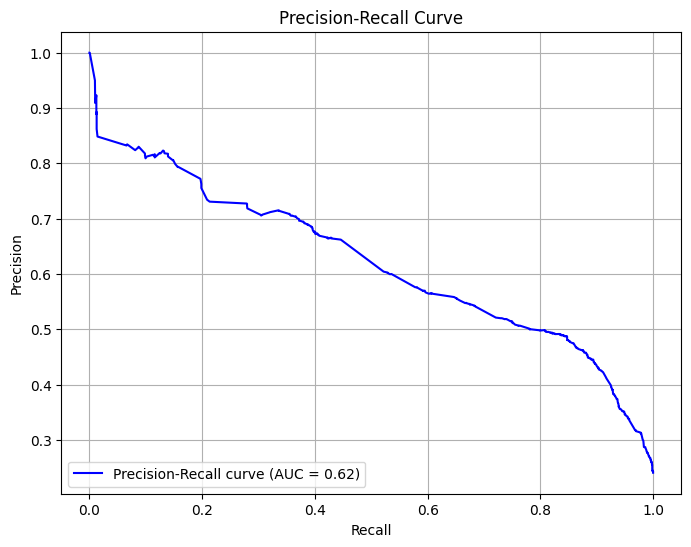

In [237]:
start_time = time.time()

t_scores = pd.Series(dtype=np.float64)
X_train_help['y'] = y_train

for column in X_train_help.columns.drop('y'):
    X_pos = X_train_help[X_train_help['y'] == 1][column]
    X_neg = X_train_help[X_train_help['y'] == 0][column]

    # Вычисляем статистики
    mu_pos, mu_neg = X_pos.mean(), X_neg.mean()
    sigma_pos, sigma_neg = X_pos.std(ddof=1), X_neg.std(ddof=1)
    n_pos, n_neg = len(X_pos), len(X_neg)

    t_stat = abs(mu_pos - mu_neg) / np.sqrt((n_pos * sigma_pos**2 + n_neg * sigma_neg**2) / (n_pos + n_neg))
    t_scores[column] = t_stat

sorted_features = t_scores.sort_values(ascending=False).index[:40]
top_40_features = sorted_features[:40]
X_train_help = X_train_help.drop(columns=['y'], axis=1)

X_train_t = X_train_help[top_40_features]
X_test_t = X_test_help[top_40_features]

# Конец замера времени
finish_time = time.time() - start_time
print(finish_time, 'секунд')

model = LogisticRegression()
model.fit(X_train_t, y_train)

# Оценка качества модели
y_pred = model.predict_proba(X_test_t)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_pred)
print(f'AUC-PR: {auc_pr}' )
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

In [232]:
t_scores

education_ Doctorate                 0.002468
education_ Prof-school               0.009760
occupation_ Priv-house-serv          0.015186
education_ Masters                   0.000797
marital-status_ Married-AF-spouse    0.029280
                                       ...   
relationship_ Unmarried              0.001127
native-country_ Vietnam              0.003613
occupation_ Armed-Forces             0.006527
workclass_ ?                         0.002179
y                                         inf
Length: 103, dtype: float64

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

я больше не могу это делать переедьте меня камазом.....

In [260]:
k=40
m=3
eps=0.01
all_features = list(X_train_help.columns)
prev_auc_pr = 0
iteration = 0
start = time.time()
while len(all_features) > k:
  iteration += 1
  model = LogisticRegression()
  model.fit(X_train_help[all_features], y_train)
  imp = np.abs(model.coef_[0])
  imp_scores = pd.Series(imp, index=all_features)

  y_pred = model.predict_proba(X_test_help[all_features])[:, 1]
  auc_pr = average_precision_score(y_test, y_pred)
  if iteration > 1 and prev_auc_pr > eps:
        print("Ухудшение качества более чем на ε. Прерываем.")
        break
  num_to_remove = min(len(all_features) - k, m)
  least_important_features = imp_scores.nsmallest(num_to_remove).index.tolist()
  for feature in least_important_features:
      all_features.remove(feature)
finish = time.time()
print(finish-start, 'секунд')


3.5797722339630127 секунд


Финальный AUC-PR: 0.6574786955413302


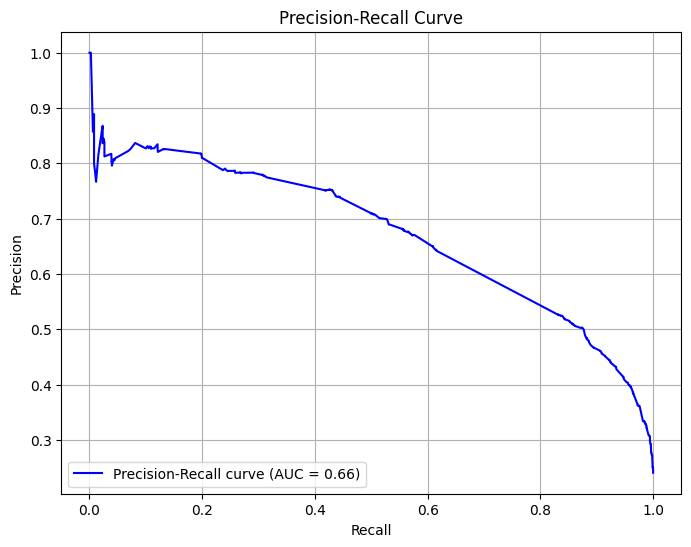

In [261]:
final_model = LogisticRegression()
final_model.fit(X_train_help[all_features], y_train)
final_y_pred = final_model.predict_proba(X_test_help[all_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, final_y_pred)
final_auc_pr = average_precision_score(y_test, final_y_pred)

print(f"Финальный AUC-PR: {final_auc_pr}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {final_auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [277]:
k=40
m=3
eps=0.01
all_features = []
choose = list(X_train_help.columns)
prev_auc_pr = 0
iteration = 0
start = time.time()
all_features = choose[:m]  

while len(all_features) < k:
  iteration += 1
  model = LogisticRegression()
  model.fit(X_train_help[all_features], y_train)
  imp = np.abs(model.coef_[0])
  imp_scores = pd.Series(imp, index=all_features)

  y_pred = model.predict_proba(X_test_help[all_features])[:, 1]
  auc_pr = average_precision_score(y_test, y_pred)
  if iteration > 1 and prev_auc_pr - auc_pr > eps:
        print("Ухудшение качества более чем на ε. Прерываем.")
        break
  prev_auc_pr = auc_pr
  num_to_add = min(len(choose) - k, m)
  most_important_features = imp_scores.nlargest(num_to_add).index.tolist()
  for feature in most_important_features:
      all_features.append(feature)
finish = time.time()
print(finish-start, 'секунд')


0.33814072608947754 секунд


Финальный AUC-PR: 0.26128647154693785


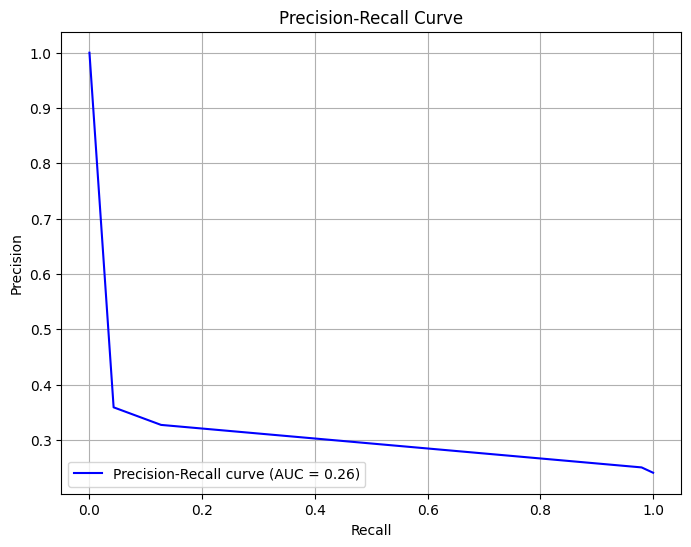

In [278]:
final_model = LogisticRegression()
final_model.fit(X_train_help[all_features], y_train)
final_y_pred = final_model.predict_proba(X_test_help[all_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, final_y_pred)
final_auc_pr = average_precision_score(y_test, final_y_pred)

print(f"Финальный AUC-PR: {final_auc_pr}")
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {final_auc_pr:.2f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

хааааааааа

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** ээээээээээ самым эффективным оказался метод, когда мы отбираем по весам признаки, как говорится все гениальное просто. Плюс многие идеи оказались какими то совсем вредительскими, это странно, но наверное объяснимо...... Метод-обертки тоже хороший, в целом он и звучит хорошо, убираем признаки, которые плохо влияют на качество, отбор, базирующийся на т-статистике тоже хороший. Вооооот

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [328]:
df = pd.read_csv('bank-additional.csv', sep=';')

In [329]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [330]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [332]:
# your code here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

In [282]:
from collections import defaultdict
from sklearn.model_selection import KFold
category = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        column_transformer = ColumnTransformer(
        transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), category),
        ('scaler', StandardScaler(), numerical)
                ], 

                )

        pipeline = Pipeline(steps=[
                ('preprocessor', column_transformer),
                ('classifier', LogisticRegression())
                    ])

        pipeline.fit(X_train, y_train)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        metric_dict = {
            'auc_pr': average_precision_score(y_test, y_prob),
            'auc_roc': roc_auc_score(y_test, y_prob)
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [285]:
first_attempt = cross_validate(X, y)
first_attempt

,auc_pr,auc_roc
0,0.459653,0.730253
1,0.342574,0.722250
2,0.461490,0.753481
3,0.428095,0.781449
4,0.455438,0.845719


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [290]:
from collections import defaultdict
from sklearn.model_selection import KFold
category = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        column_transformer = ColumnTransformer(
        transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), category),
        ('scaler', StandardScaler(), numerical)
                ], 

                )

        pipeline = Pipeline(steps=[
                ('preprocessor', column_transformer),
                ('classifier', LogisticRegression())
                    ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        metric_dict = {
            'auc_pr': average_precision_score(y_test, y_prob),
            'auc_roc': roc_auc_score(y_test, y_prob),
            'profit':  2 * ((y_pred == 1) & (y_test == 0)).sum() + 10 * ((y_pred == 1) & (y_test == 1)).sum()

        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

In [291]:
second_attemp = cross_validate(X, y)
second_attemp

,auc_pr,auc_roc,profit
0,0.459653,0.730253,248
1,0.342574,0.722250,144
2,0.461490,0.753481,242
3,0.428095,0.781449,252
4,0.455438,0.845719,232


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [292]:
# your code here
from collections import defaultdict
from sklearn.model_selection import KFold
import random
category = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        column_transformer = ColumnTransformer(
        transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), category),
        ('scaler', StandardScaler(), numerical)
                ], 

                )

        pipeline = Pipeline(steps=[
                ('preprocessor', column_transformer),
                ('classifier', LogisticRegression())
                    ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        metric_dict = {
            'auc_pr': average_precision_score(y_test, y_prob),
            'auc_roc': roc_auc_score(y_test, y_prob),
            'profit':  2 * ((y_pred == 1) & (y_test == 0)).sum() + random.uniform(0, 20) * ((y_pred == 1) & (y_test == 1)).sum()

        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

In [293]:
third_attemp = cross_validate(X, y)
third_attemp

,auc_pr,auc_roc,profit
0,0.459653,0.730253,60.649030
1,0.342574,0.722250,164.483520
2,0.461490,0.753481,301.323796
3,0.428095,0.781449,84.798211
4,0.455438,0.845719,60.928717


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [ ]:
# your code here
from collections import defaultdict
from sklearn.model_selection import KFold
import random
category = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    C=1
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        column_transformer = ColumnTransformer(
        transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), category),
        ('scaler', StandardScaler(), numerical)
                ], 

                )

        pipeline = Pipeline(steps=[
                ('preprocessor', column_transformer),
                ('classifier', LogisticRegression(C=C))
                    ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        metric_dict = {
            'auc_pr': average_precision_score(y_test, y_prob),
            'auc_roc': roc_auc_score(y_test, y_prob),
            'profit':  2 * ((y_pred == 1) & (y_test == 0)).sum() + random.uniform(0, 20) * ((y_pred == 1) & (y_test == 1)).sum()

        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

0.001
0.0027825594022071257
0.007742636826811269
0.021544346900318832
0.05994842503189409
0.1668100537200059
0.46415888336127775
1.2915496650148828
3.593813663804626
10.0


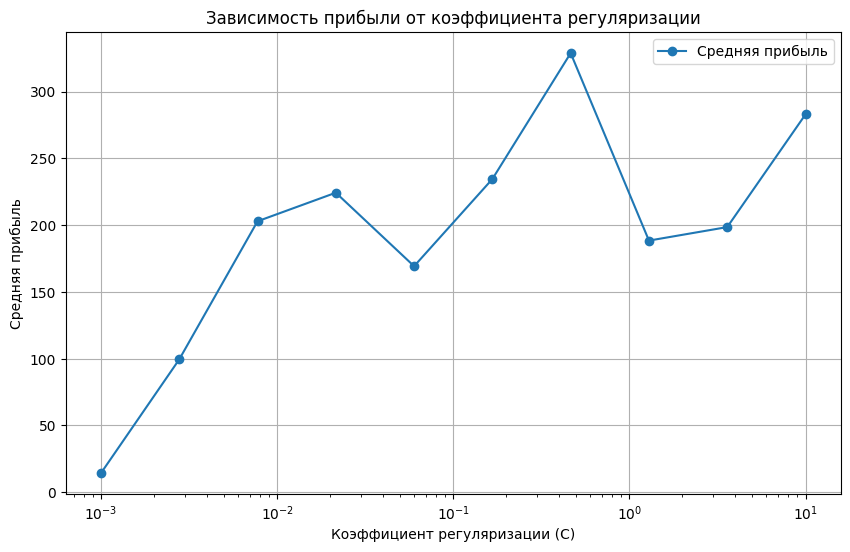

In [300]:
regularization_values = np.logspace(-3, 1, 10)
results = []
for C in regularization_values:
    print(C)
    metrics_df = cross_validate(X, y, C=C)
    mean_profit = metrics_df['profit'].mean()
    results.append({'C': C, 'mean_profit': mean_profit})
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(results_df['C'], results_df['mean_profit'], marker='o', label='Средняя прибыль')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации (C)')
plt.ylabel('Средняя прибыль')
plt.title('Зависимость прибыли от коэффициента регуляризации')
plt.legend()
plt.grid(True)
plt.show()

Видно, что мы получаем выигрышь, прибыль максимально при C=0.46415888336127775

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

0.001
0.0027825594022071257
0.007742636826811269
0.021544346900318832
0.05994842503189409
0.1668100537200059
0.46415888336127775
1.2915496650148828
3.593813663804626
10.0


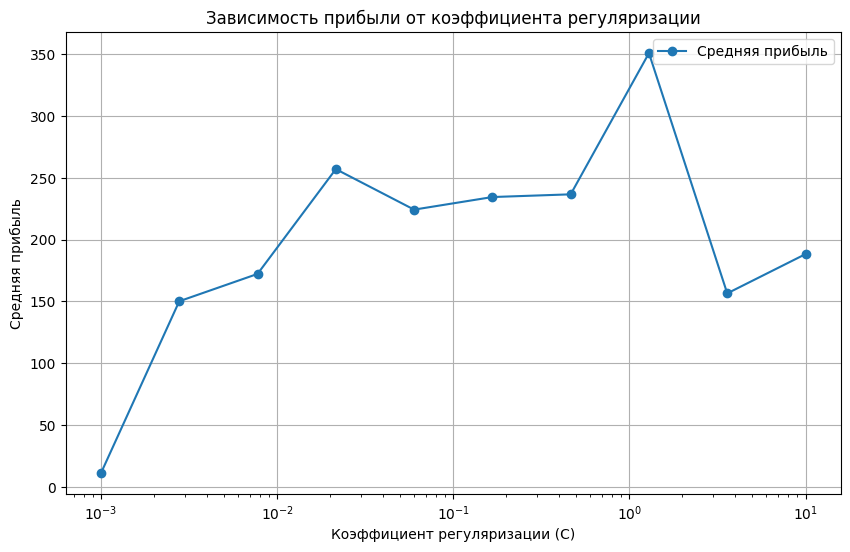

In [301]:
regularization_values = np.logspace(-3, 1, 10)
results = []
for C in regularization_values:
    print(C)
    metrics_df = cross_validate(X, y, C=C)
    mean_profit = metrics_df['profit'].mean()
    results.append({'C': C, 'mean_profit': mean_profit})
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(results_df['C'], results_df['mean_profit'], marker='o', label='Средняя прибыль')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации (C)')
plt.ylabel('Средняя прибыль')
plt.title('Зависимость прибыли от коэффициента регуляризации')
plt.legend()
plt.grid(True)
plt.show()

0.001
0.0027825594022071257
0.007742636826811269
0.021544346900318832
0.05994842503189409
0.1668100537200059
0.46415888336127775
1.2915496650148828
3.593813663804626
10.0


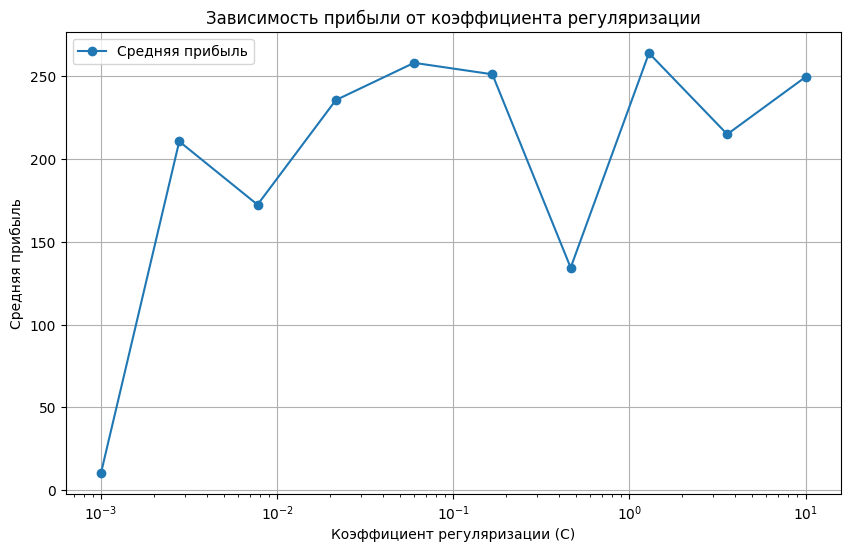

In [302]:
regularization_values = np.logspace(-3, 1, 10)
results = []
for C in regularization_values:
    print(C)
    metrics_df = cross_validate(X, y, C=C)
    mean_profit = metrics_df['profit'].mean()
    results.append({'C': C, 'mean_profit': mean_profit})
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(results_df['C'], results_df['mean_profit'], marker='o', label='Средняя прибыль')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации (C)')
plt.ylabel('Средняя прибыль')
plt.title('Зависимость прибыли от коэффициента регуляризации')
plt.legend()
plt.grid(True)
plt.show()

0.001
0.0027825594022071257
0.007742636826811269
0.021544346900318832
0.05994842503189409
0.1668100537200059
0.46415888336127775
1.2915496650148828
3.593813663804626
10.0


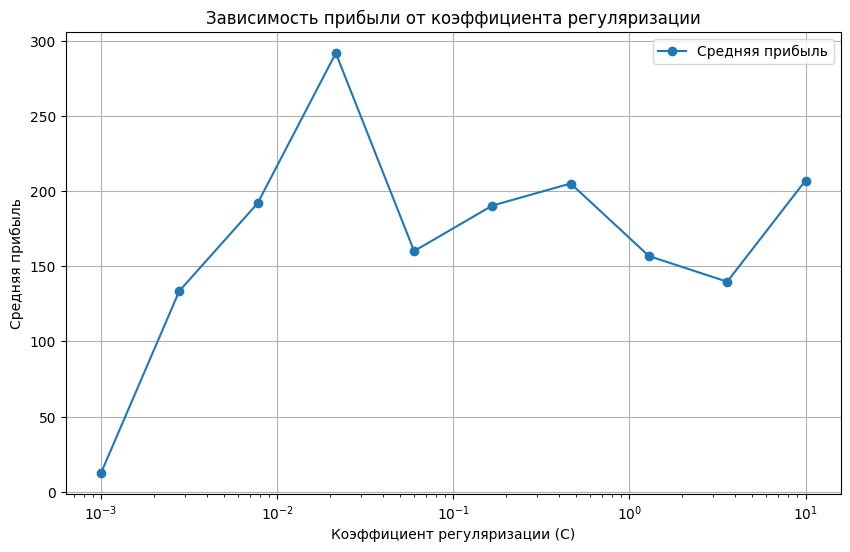

In [303]:
regularization_values = np.logspace(-3, 1, 10)
results = []
for C in regularization_values:
    print(C)
    metrics_df = cross_validate(X, y, C=C)
    mean_profit = metrics_df['profit'].mean()
    results.append({'C': C, 'mean_profit': mean_profit})
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(results_df['C'], results_df['mean_profit'], marker='o', label='Средняя прибыль')
plt.xscale('log')
plt.xlabel('Коэффициент регуляризации (C)')
plt.ylabel('Средняя прибыль')
plt.title('Зависимость прибыли от коэффициента регуляризации')
plt.legend()
plt.grid(True)
plt.show()

Результаты разные каждые раз, даже закономерность сложно вывести, но могу предположить, что похожее в этих графиках то, что изначально они растут до какого то максимального значения, а потом уходят кто в лес кто по дрова

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ precision = TP/(TP+FP), recall=TP/(TP+FN), мне кажется, что recall важнее, так как он показывает долю тех, кому позвонят и кто купит от всех, кто был готов купить. И для бизнеса важнее не потерять клиента, которы был готов купить, но попал в 0 категорию, чем позвонить лишнему (FP из recall)



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [313]:
# your code here
from collections import defaultdict
from sklearn.model_selection import KFold
import random
category = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    C=0,
    threshold=0
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        column_transformer = ColumnTransformer(
        transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), category),
        ('scaler', StandardScaler(), numerical)
                ], 

                )

        pipeline = Pipeline(steps=[
                ('preprocessor', column_transformer),
                ('classifier', LogisticRegression(C=C))
                    ])

        pipeline.fit(X_train, y_train)
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)
        conv_rate = ((y_pred == 1) & (y_test == 1)).sum()
        positive_predictions = (y_pred == 1).sum()


        if positive_predictions > 0:
            conv_rate = conv_rate / positive_predictions
        else:
            conv_rate = 0

        metric_dict = {
            'auc_pr': average_precision_score(y_test, y_prob),
            'auc_roc': roc_auc_score(y_test, y_prob),
            'profit':  2 * ((y_pred == 1) & (y_test == 0)).sum() + random.uniform(0, 20) * ((y_pred == 1) & (y_test == 1)).sum(),
            #добавим эстетичную бизнес метрику "КОНВЕРСИЯ"
            'conv_rate': conv_rate


        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

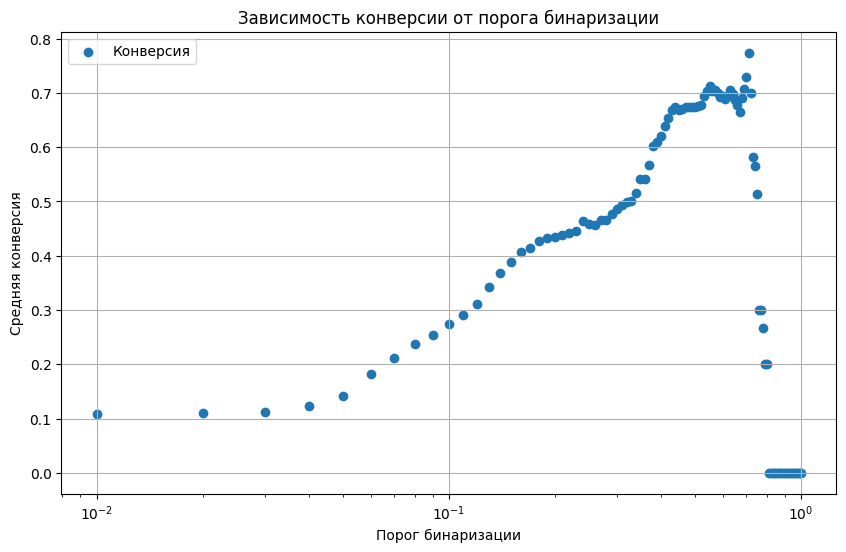

In [323]:
grid = np.arange(0, 1.01, 0.01)
random_grid = np.random.choice(grid, size=10)
for i in grid:
    cross_validate(X, y, C=0.021544346900318832, threshold=i)
    metrics_df = cross_validate(X, y,C=0.021544346900318832, threshold=i)
    mean_profit = metrics_df['conv_rate'].mean()
    results.append({'threshold': i, 'conv_rate': mean_profit})
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.scatter(results_df['threshold'], results_df['conv_rate'], marker='o', label='Конверсия')
plt.xscale('log')
plt.xlabel('Порог бинаризации')
plt.ylabel('Средняя конверсия')
plt.title('Зависимость конверсии от порога бинаризации')
plt.legend()
plt.grid(True)
plt.show()

In [374]:
results_df['conv_rate'].max()

0.7733333333333332

In [376]:
results_df['threshold'].loc[results_df['conv_rate'] == 0.7733333333333332] #максимальное значение метрики

535    0.71
Name: threshold, dtype: float64

Видно, что конверсия (здесь по сути она играет роль доли положительных исходов для объектов, которым присвоили положительный класс) растет до порога бинаризации в районе 0.7, а затем начинает падать

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




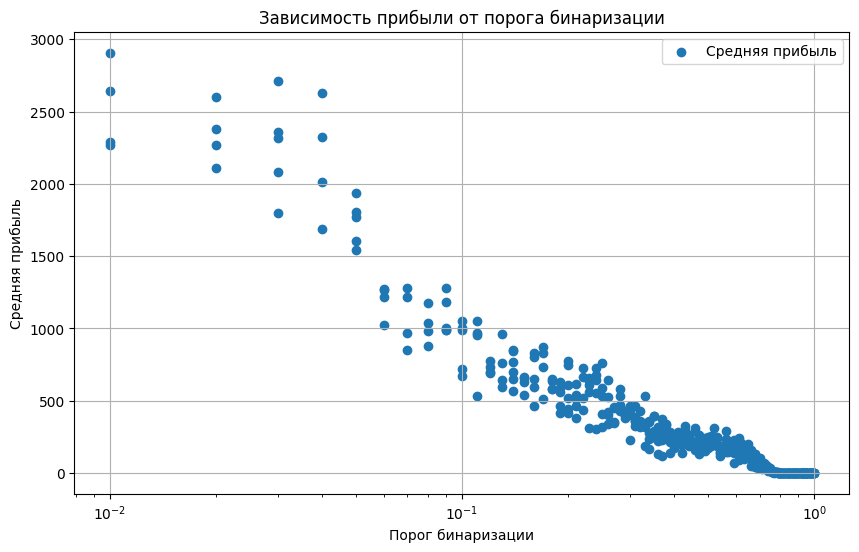

In [322]:
grid = np.arange(0, 1.01, 0.01)
random_grid = np.random.choice(grid, size=10)
for i in grid:
    cross_validate(X, y, C=0.021544346900318832, threshold=i)
    metrics_df = cross_validate(X, y,C=0.021544346900318832, threshold=i)
    mean_profit = metrics_df['profit'].mean()
    results.append({'threshold': i, 'mean_profit': mean_profit})
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.scatter(results_df['threshold'], results_df['mean_profit'], marker='o', label='Средняя прибыль')
plt.xscale('log')
plt.xlabel('Порог бинаризации')
plt.ylabel('Средняя прибыль')
plt.title('Зависимость прибыли от порога бинаризации')
plt.legend()
plt.grid(True)
plt.show()

А вот у прибыль отрицательная зависимость, чем выше порог бинаризации, тем ниже прибыль, значит recall все таки важнее

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Если я правильно поняла задачу, то колл-центр получает деньги за сам факт обзванивания клиентов. При этом деньги, которые колл-центр получает за заключение какой то сделки лежат от 0 до 20, то есть за закрытую сделку можно получить даже меньше, чем за неудачный звонок. С этой точки зрения, колл центру выгоднее отнести к положительному классу как можно больше людей, чтобы получить как можно больше денег за звонки, поэтому порог бинаризации отрицательно связан с прибылью.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [395]:
#наша навороченная регрессия
df = cross_validate(X,y, C=1, threshold=0)
a = df['conv_rate'].values
print('conv_rate', df['conv_rate'].mean())

conv_rate 0.10948931802899646


In [396]:
#наша навороченная регрессия
df = cross_validate(X,y, C=0.021544346900318832, threshold=0.71)
b = df['conv_rate'].values
print('conv_rate', df['conv_rate'].mean())

conv_rate 0.7733333333333332


Yу я в целом дурацкую метрику выбрала конечно, она не особо связана с прибылью из-за специфики бизнеса... Но лан почему нет

In [397]:
from scipy import stats

t_stat, p_value = stats.ttest_rel(a, b)
alpha = 0.05
if p_value < alpha:
    print(f"Результаты статистически значимы (p-value = {p_value:.4f})")
else:
    print(f"Нет статистически значимой разницы (p-value = {p_value:.4f})")

Результаты статистически значимы (p-value = 0.0039)


# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ В ОБЩЕМ я смешала макароны, яйца, сыр и ветчину и все это пожарила

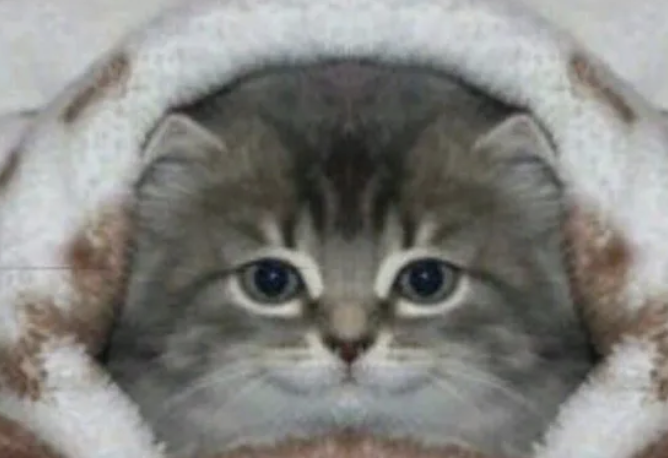